# Linking

Linking assigns the detected features and segments in each timestep to trajectories, to enable an analysis of their time evolution.

In [88]:
import tobac
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
%matplotlib inline

Since it has a time dimension, the sample data from the testting utilities is also suitable for a demonstation of this step. At first loading in the data and performing the usual feature detection and segmentation is required:

In [50]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs_inv()

dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=1)

mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=1)

Now the linking via trackpy can be performed. Notice that here the temporal spacing is also a required input. Additionally, it is necessary to provide either a maximum speed *v_max* or a maximum search range *d_max*. Here we use a maximum speed of 100 m/s:

In [65]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100)

Frame 69: 2 trajectories present.


The output tells us, that in frame 69 two trajecteries where present. If we checkout this frame via imshow, we can see that this corresponds to the two present features there, which are assigned to different trajectories.

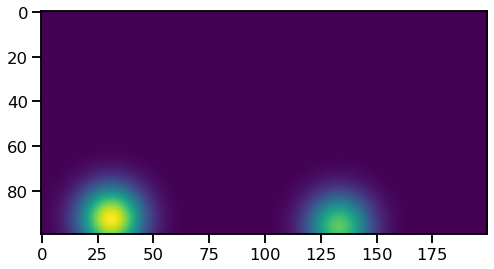

In [72]:
plt.figure(figsize = (8, 8))
plt.imshow(data[69])
plt.show()

The track dataset contains two new variables, *cell* and *time_cell*. The first assigns the features to one of the found trajectories by an integer and the second specifies how long the feature has been present already in the data.

In [74]:
track[['cell', 'time_cell']]

<xarray.Dataset>
Dimensions:    (index: 110)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108 109
Data variables:
    cell       (index) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 3.0 2.0 3.0 2.0 3.0
    time_cell  (index) timedelta64[ns] 00:00:00 00:01:00 ... 00:29:00 00:19:00

Since we know that this dataset contains 3 features, whe can visualize the found tracks with masks created from the *cell* variable:

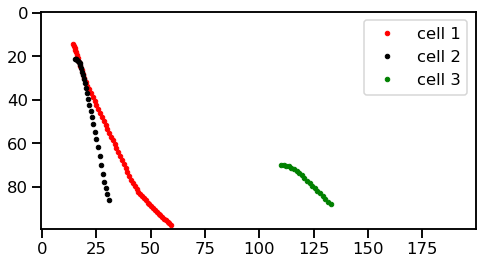

In [229]:
mask_1 = track['cell'] == 1
mask_2 = track['cell'] == 2
mask_3 = track['cell'] == 3

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))

ax.imshow(data[0], alpha = 0)
ax.plot(track.where(mask_1)['hdim_2'], track.where(mask_1)['hdim_1'], 'r.', label = 'cell 1')
ax.plot(track.where(mask_2)['hdim_2'], track.where(mask_2)['hdim_1'], 'k.', label = 'cell 2')
ax.plot(track.where(mask_3)['hdim_2'], track.where(mask_3)['hdim_1'], 'g.', label = 'cell 3')
ax.legend()
plt.show()

## v_max

If the maximum speed is reduced, more trajectories are found.

Frame 69: 2 trajectories present.


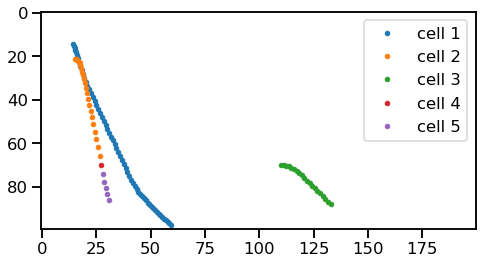

In [211]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 70)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

## d_max

The same effect can be achieved by reducing the maximum search range.

Frame 69: 2 trajectories present.


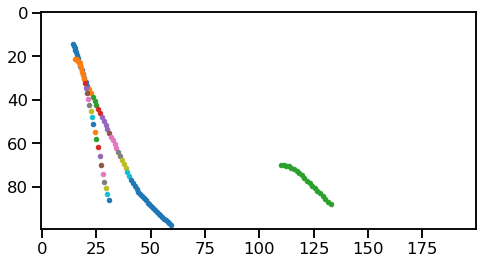

In [214]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, d_max = 2000)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

#ax.legend()
plt.show()

## d_min

isnt working as intended?

Frame 69: 2 trajectories present.


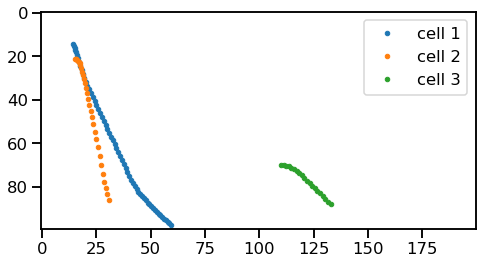

In [159]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, d_min = 6000, v_max = 100)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

## subnetwork_size

Frame 69: 2 trajectories present.


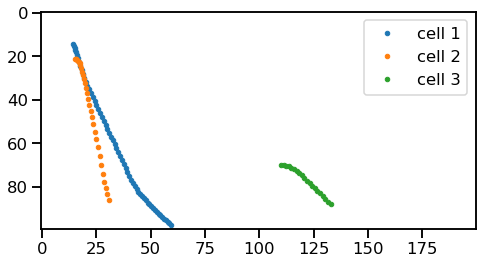

In [176]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, subnetwork_size=2)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

In [218]:
tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, subnetwork_size=0)

Frame 69: 2 trajectories present.


<xarray.Dataset>
Dimensions:                  (index: 110)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 105 106 107 108 109
Data variables: (12/16)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 67 67 68 68 69 69
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 14.27 15.23 16.16 ... 85.86 87.98
    hdim_2                   (index) float64 14.27 14.67 15.06 ... 30.86 132.8
    num                      (index) int64 908 984 1061 1135 ... 1131 1273 1018
    threshold_value          (index) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                       ...
    projection_y_coordinate  (index) float64 1.427e+04 1.467e+04 ... 1.328e+05
    latitude                 (index) object 24.14 24.15 24.16 ... 24.86 24.88
    longitude                (index) object 150.1 150.1 150.2 ... 150.3 151.3
    ncells                   (index) float64 904.0 983.0 ... 1.015e+03 1.015e+03
    cell                     (index) float64 1.0 1.0 1.0 1.0 ... 2.0 3.0 2.0 3.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:19:00

In [219]:
tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, subnetwork_size=1000)

Frame 69: 2 trajectories present.


<xarray.Dataset>
Dimensions:                  (index: 110)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 105 106 107 108 109
Data variables: (12/16)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 67 67 68 68 69 69
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 14.27 15.23 16.16 ... 85.86 87.98
    hdim_2                   (index) float64 14.27 14.67 15.06 ... 30.86 132.8
    num                      (index) int64 908 984 1061 1135 ... 1131 1273 1018
    threshold_value          (index) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                       ...
    projection_y_coordinate  (index) float64 1.427e+04 1.467e+04 ... 1.328e+05
    latitude                 (index) object 24.14 24.15 24.16 ... 24.86 24.88
    longitude                (index) object 150.1 150.1 150.2 ... 150.3 151.3
    ncells                   (index) float64 904.0 983.0 ... 1.015e+03 1.015e+03
    cell                     (index) float64 1.0 1.0 1.0 1.0 ... 2.0 3.0 2.0 3.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:19:00

## stups

Frame 69: 2 trajectories present.


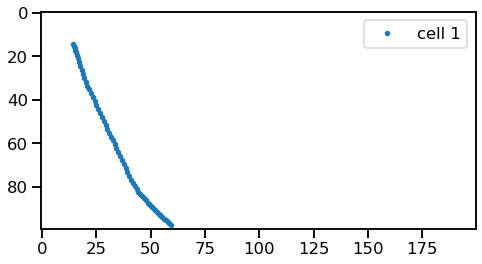

In [209]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, stubs = 50)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

## order

Frame 69: 2 trajectories present.


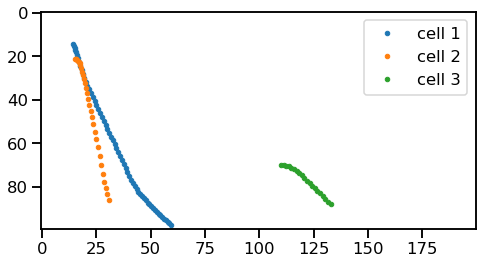

In [226]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, order = 1)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

In [202]:
track

<xarray.Dataset>
Dimensions:                  (index: 110)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 ... 105 106 107 108 109
Data variables: (12/16)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 67 67 68 68 69 69
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 14.27 15.23 16.16 ... 85.86 87.98
    hdim_2                   (index) float64 14.27 14.67 15.06 ... 30.86 132.8
    num                      (index) int64 908 984 1061 1135 ... 1131 1273 1018
    threshold_value          (index) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                       ...
    projection_y_coordinate  (index) float64 1.427e+04 1.467e+04 ... 1.328e+05
    latitude                 (index) object 24.14 24.15 24.16 ... 24.86 24.88
    longitude                (index) object 150.1 150.1 150.2 ... 150.3 151.3
    ncells                   (index) float64 904.0 983.0 ... 1.015e+03 1.015e+03
    cell                     (index) float64 nan nan nan nan ... nan nan nan nan
    time_cell                (index) object nan nan nan nan ... nan nan nan nan

<IPython.core.display.Javascript object>


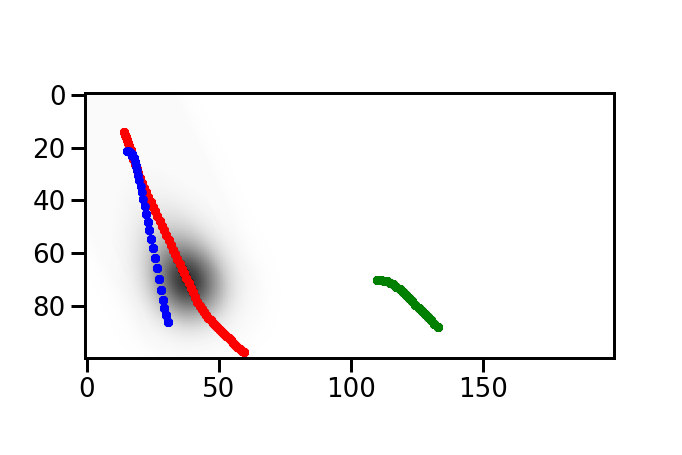

In [102]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
mask_1 = track['cell'] == 1
mask_2 = track['cell'] == 2
mask_3 = track['cell'] == 3

fig, ax = plt.subplots(ncols = 1, nrows = 1)

def animate(i):

    ax.imshow(data[i], alpha = 0.2, cmap = 'Greys')
    ax.plot(track.where(mask_1)['hdim_2'], track.where(mask_1)['hdim_1'], 'r.')
    ax.plot(track.where(mask_2)['hdim_2'], track.where(mask_2)['hdim_1'], 'b.')
    ax.plot(track.where(mask_3)['hdim_2'], track.where(mask_3)['hdim_1'], 'g.')
            
FuncAnimation(fig, animate, interval=100)

In [78]:
tobac.plot.plot_tracks_mask_field_loop(track, data, mask, features)

AttributeError: module 'tobac.plot' has no attribute 'plot_tracks_mask_field_loop'

In [80]:
tobac.plot.plot_tracks_mask_field(track, data, mask, features)

ValueError: axes had to be cartopy.mpl.geoaxes.GeoAxesSubplot

In [54]:
mask_2

<xarray.DataArray 'cell' (index: 110)>
array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 102 103 104 105 106 107 108 109

    d_max : float, optional
        Maximum search range
        Default is None.
    d_min : float, optional
        Variations in the shape of the regions used to determine the
        positions of the features can lead to quasi-instantaneous shifts
        of the position of the feature by one or two grid cells even for
        a very high temporal resolution of the input data, potentially
        jeopardising the tracking procedure. To prevent this, tobac uses
        an additional minimum radius of the search range. [5]_
        Default is None.
    subnetwork_size : int, optional
        Maximum size of subnetwork for linking. Default is None.
    v_max : float, optional
        Speed at which features are allowed to move. Default is None.
    memory : int, optional
        Number of output timesteps features allowed to vanish for to
        be still considered tracked. Default is 0.
        .. warning :: This parameter should be used with caution, as it
                     can lead to erroneous trajectory linking,
                     espacially for data with low time resolution. [5]_
    stubs : int, optional
        Minimum number of timesteps of a tracked cell to be reported
        Default is 1
    time_cell_min : float, optional
        Minimum length in time of tracked cell to be reported in minutes
        Default is None.
    order : int, optional
        Order of polynomial used to extrapolate trajectory into gaps and
        ond start and end point.
        Default is 1.
    extrapolate : int, optional
        Number or timesteps to extrapolate trajectories.
        Default is 0.
    method_linking : {'random', 'predict'}, optional
        Flag choosing method used for trajectory linking.
        Default is 'random'.
    adaptive_step : float, optional
        Reduce search range by multiplying it by this factor.
    adaptive_stop : float, optional
        If not None, when encountering an oversize subnet, retry by progressively
        reducing search_range until the subnet is solvable. If search_range
        becomes <= adaptive_stop, give up and raise a SubnetOversizeException.
        Default is None
    cell_number_start : int, optional
        Cell number for first tracked cell.
        Default is 1

In [38]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, d_min = 10, d_max=1)

Frame 69: 2 trajectories present.


In [32]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy)

UnboundLocalError: local variable 'search_range' referenced before assignment